In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
Image_size=256
Batch_size=32
Channels=3
Epochs=20

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"/content/drive/MyDrive/pizza_not_pizza",  # Use raw string (r"")
    shuffle=True,
    image_size=(Image_size, Image_size),
    batch_size=Batch_size
)


Found 1966 files belonging to 2 classes.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class_names= dataset.class_names
class_names

['not_pizza', 'pizza']

In [7]:
len(dataset)

62

In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1]


In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])
    print("label",label_batch[0])

tf.Tensor(
[[[131.125 170.5   178.25 ]
  [134.5   171.625 181.625]
  [133.25  166.25  177.25 ]
  ...
  [161.625 119.625  65.375]
  [154.25  120.5    66.5  ]
  [189.125 161.375 106.625]]

 [[109.375 144.625 148.625]
  [136.    169.75  176.75 ]
  [148.625 179.375 190.   ]
  ...
  [161.    119.25   66.125]
  [156.25  123.625  70.125]
  [193.    167.125 113.25 ]]

 [[104.875 133.25  130.25 ]
  [117.625 146.    148.25 ]
  [134.625 164.25  172.25 ]
  ...
  [160.375 122.5    71.125]
  [158.5   128.5    78.25 ]
  [196.    172.375 121.75 ]]

 ...

 [[ 95.125 124.125 141.125]
  [ 96.625 125.25  144.125]
  [ 99.    128.125 148.   ]
  ...
  [128.125 190.625 234.875]
  [124.375 187.875 231.375]
  [116.125 181.125 223.125]]

 [[ 97.    125.    147.5  ]
  [ 97.75  125.375 149.375]
  [ 99.    127.    153.875]
  ...
  [120.875 183.875 227.875]
  [121.375 184.875 228.375]
  [124.375 189.375 231.375]]

 [[ 92.75  119.75  148.   ]
  [ 93.125 121.625 152.125]
  [ 95.5   124.375 157.25 ]
  ...
  [120.    18

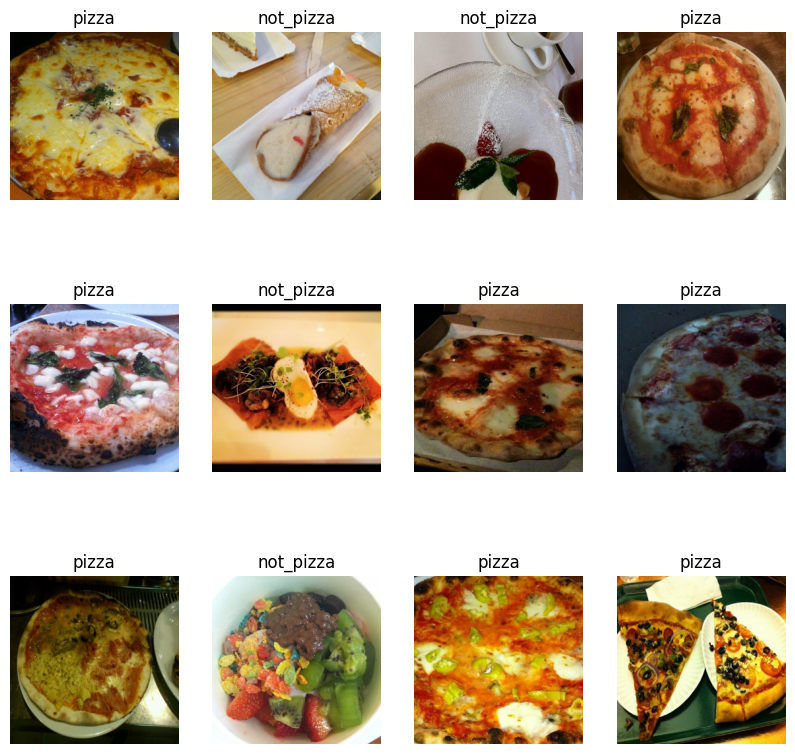

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [11]:
image_count=len(dataset)
image_count

62

In [12]:
train_size=int(image_count*0.8)
train_ds=dataset.take(train_size)
test_ds=dataset.skip(train_size)

In [13]:
print(len(train_ds))
print(len(test_ds))

49
13


In [14]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [15]:
test_ds=test_ds.skip(6)
len(test_ds)

7

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

49

In [19]:
len(test_ds)

7

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_size, Image_size),
    tf.keras.layers.Rescaling(1.0/255)
])


In [51]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])

In [23]:
for image, label in train_ds.take(1):
    print(image.shape)

(32, 256, 256, 3)


In [55]:
input_shape=(Batch_size,Image_size,Image_size,Channels)
n_classes=2

model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(32,activation='relu'),
    layers.Dense(n_classes,activation="sigmoid"),

])
model.build(input_shape=input_shape)

In [53]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 32)               │        73,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 2)                │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,002 (796.88 KB)

 Trainable params: 204,002 (796.88 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [61]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True
)


In [62]:
history=model.fit(
    train_ds,
    epochs=50,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.4860 - loss: 0.6966 - val_accuracy: 0.5000 - val_loss: 0.6830
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.5595 - loss: 0.6693 - val_accuracy: 0.5920 - val_loss: 0.6611
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6494 - loss: 0.6453 - val_accuracy: 0.6724 - val_loss: 0.6237
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.7023 - loss: 0.5957 - val_accuracy: 0.6839 - val_loss: 0.6209
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7284 - loss: 0.5769 - val_accuracy: 0.7184 - val_loss: 0.5605
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7188 - loss: 0.5473 - val_accuracy: 0.6839 - val_loss: 0.5739
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7645 - loss: 0.4944 - val_accuracy: 0.7414 - val_loss: 0.5393
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.7459 - loss: 0.5183 - val_accuracy: 0.7816 - v

In [63]:
scores=model.evaluate(test_ds)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8204 - loss: 0.3353


In [64]:
scores

[0.3296249210834503, 0.8392857313156128]

In [65]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 49}

In [33]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [66]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

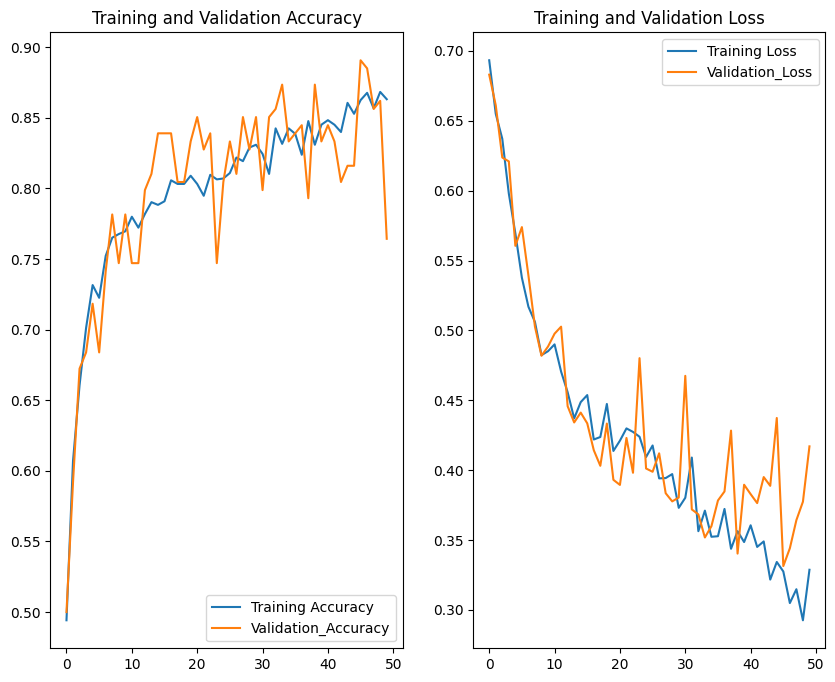

In [67]:
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
# Use len(acc) instead of Epochs to ensure x and y have the same length
plt.plot(range(len(acc)),acc,label='Training Accuracy')
plt.plot(range(len(val_acc)),val_acc,label="Validation_Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.subplot(1,2,2)
# Use len(loss) instead of Epochs to ensure x and y have the same length
plt.plot(range(len(loss)),loss,label='Training Loss')
plt.plot(range(len(val_loss)),val_loss,label="Validation_Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

[[[  7   6  11]
  [  8   7  12]
  [  8   7  12]
  ...
  [178 190 177]
  [177 189 176]
  [180 192 179]]

 [[  8   8  10]
  [  6   6   8]
  [  7   5   8]
  ...
  [183 193 185]
  [184 194 185]
  [181 193 183]]

 [[  8   6   9]
  [  9   7  10]
  [  9   7  10]
  ...
  [182 191 187]
  [181 190 185]
  [181 191 184]]

 ...

 [[ 63  35  13]
  [ 69  41  18]
  [ 71  44  18]
  ...
  [101  84  64]
  [100  83  65]
  [ 97  80  62]]

 [[ 63  34  18]
  [ 62  33  15]
  [ 63  37  14]
  ...
  [104  89  69]
  [100  85  68]
  [ 94  78  63]]

 [[ 82  54  42]
  [ 64  36  21]
  [ 63  36  16]
  ...
  [ 89  77  56]
  [ 86  73  57]
  [ 96  82  70]]]


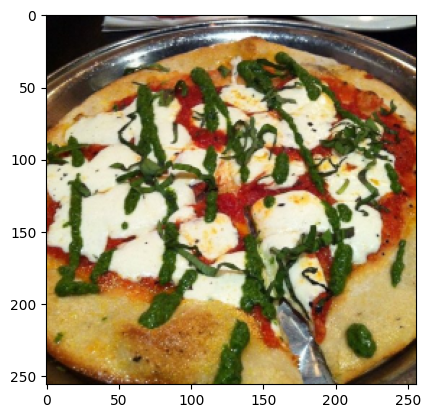

In [38]:
for images_batch, labels_batch in test_ds.take(1):
    print(images_batch[0].numpy().astype('uint8'))
    plt.imshow(images_batch[0].numpy().astype('uint8'))

First Image to predict
actual label: not_pizza
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Predicted label: not_pizza


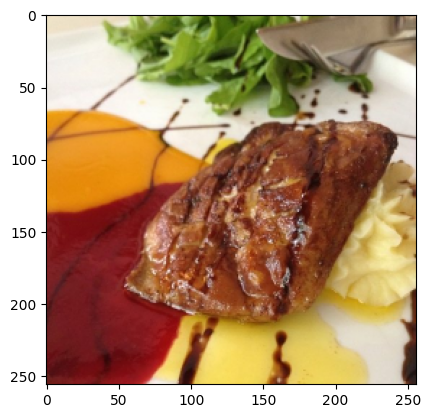

In [39]:
import numpy as np
for images_batch,label_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])


In [40]:
def predict(model,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array =tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


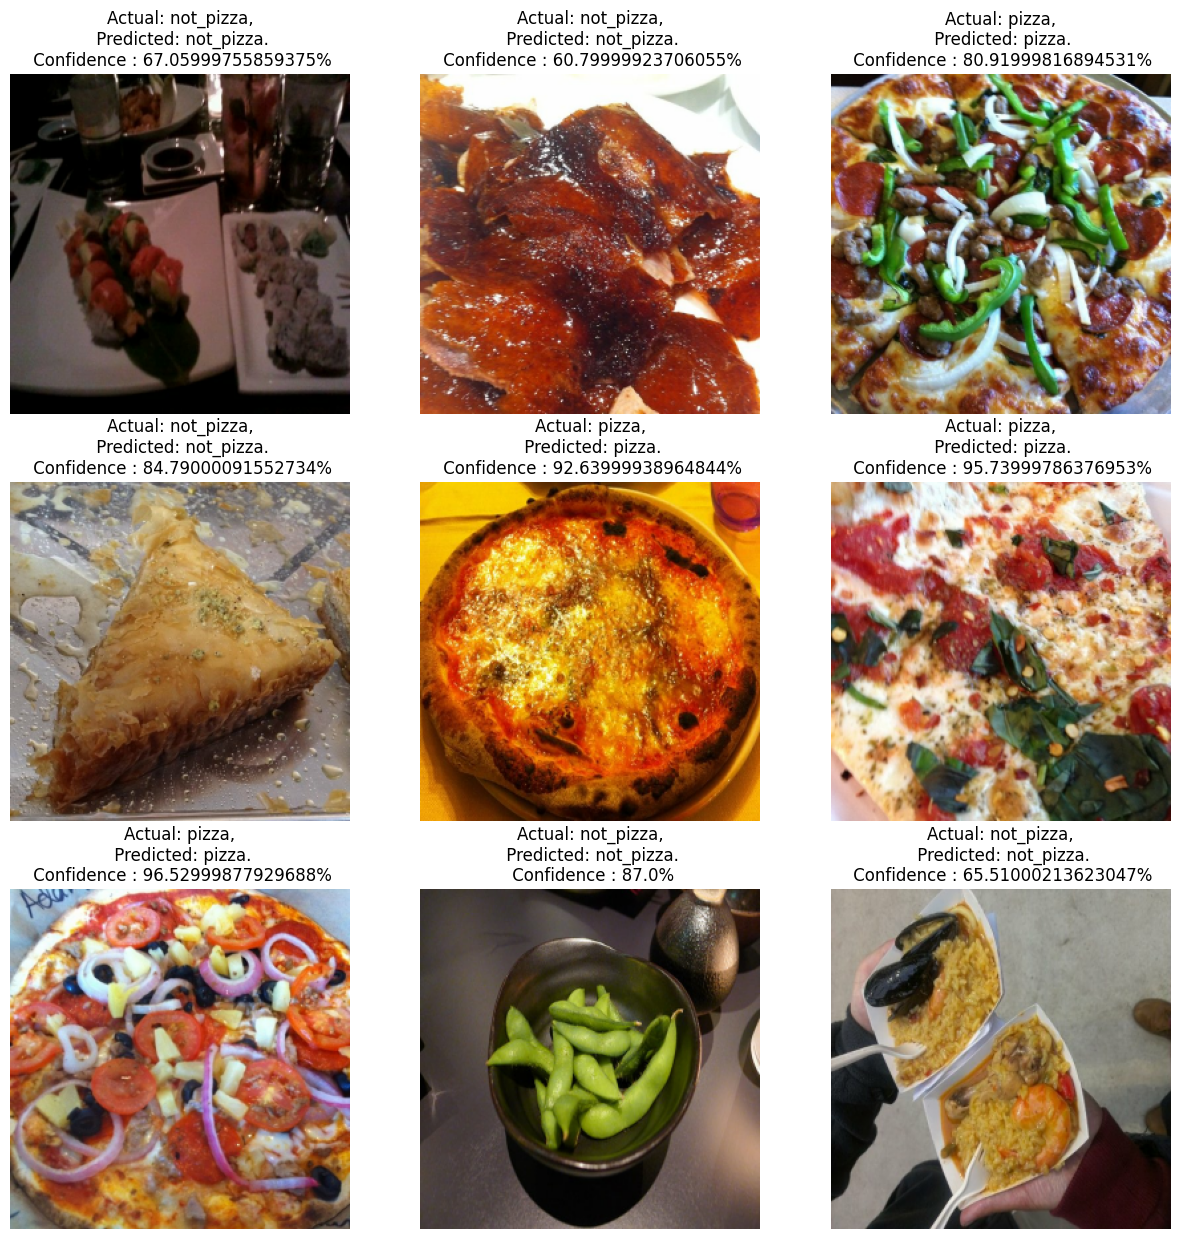

In [49]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence : {confidence}%")
        plt.axis("off")

In [42]:
# Extract true labels from tf.data.Dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert from one-hot encoding if needed
if len(y_true.shape) > 1 and y_true.shape[-1] > 1:
    y_true = np.argmax(y_true, axis=-1)  # Convert one-hot to class labels

# Ensure y_true is an array
y_true = np.array(y_true)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


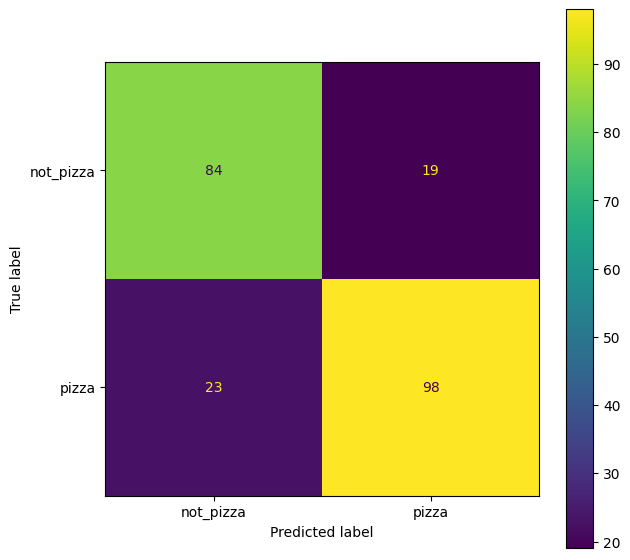

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay  # Import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(conf_mat, classes):
    """
    This function prints and plots the confusion matrix.
    """
    fig, ax = plt.subplots(figsize=(7, 7))  # Set the figure size
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=classes)
    disp.plot(include_values=True, cmap='viridis', ax=ax, xticks_rotation='horizontal')
    plt.show()

# Extract true labels and predicted labels
y_true = []
y_pred = []

# Assuming test_ds is your test dataset
for images, labels in test_ds:
    predictions = model.predict(images)  # Get predictions for the batch
    y_true.extend(labels.numpy())       # Add true labels to the list
    y_pred.extend(np.argmax(predictions, axis=1))  # Add predicted labels

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix

# Now call the function to plot the matrix
plot_confusion_matrix(conf_mat, class_names)

Confusion Matrix:
[[84 19]
 [23 98]]


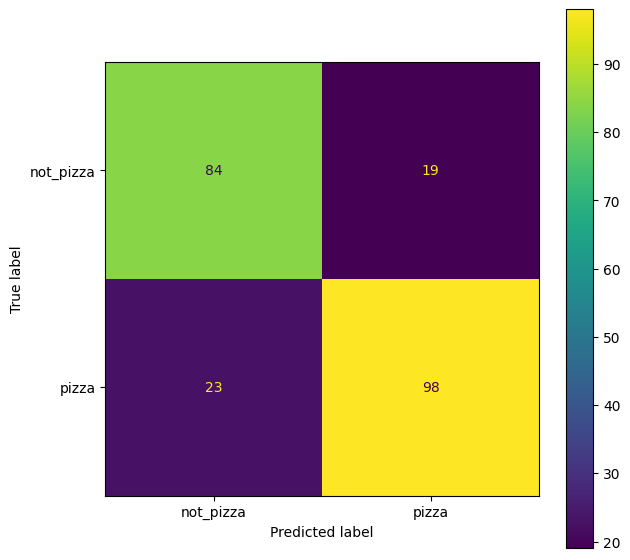

In [48]:
# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)  # Use y_pred instead of y_pred_classes

print("Confusion Matrix:")
print(conf_mat)

# Plot confusion matrix
plot_confusion_matrix(conf_mat, class_names)

In [ ]:
pip install kolmogorov-arnold-network


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

class KANLayer(layers.Layer):
    def __init__(self, units=64, activation="relu"):
        super(KANLayer, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        # Define learnable coefficients for a polynomial function (KAN uses function approximation)
        self.coefficients = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        # Apply a polynomial transformation (simplified KAN approach)
        x = tf.matmul(inputs, self.coefficients) + self.bias
        return self.activation(x)


In [ ]:
input_shape = (Batch_size, Image_size, Image_size, Channels)
n_classes = 3

model2 = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,

    # KAN Layers replacing Conv2D layers
    KANLayer(units=64, activation='relu'),  # Learnable transformation
    KANLayer(units=64, activation='relu'),
    KANLayer(units=64, activation='relu'),
    KANLayer(units=64, activation='relu'),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])


In [ ]:
# Build & Compile the model
model2.build(input_shape=input_shape)
model2.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
# Train the model
Epochs=20
history = model2.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_size,
    verbose=1,
    validation_data=val_ds,
    callbacks=[early_stopping]
)

In [ ]:
scores=model2.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

In [ ]:
print(len(acc), len(val_acc))  # Should match Epochs
print(len(loss), len(val_loss))  # Should match Epochs


In [ ]:
plt.figure(figsize=(10, 8))

# Adjust x-axis range to match the actual training epochs
epochs_range = range(len(acc))  # Instead of range(Epochs)

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title("Training and Validation Loss")

plt.show()


In [ ]:
for image_batch,label_batch in test_ds.take(1):
    print(image_batch[0].numpy().astype("uint8"))
    plt.imshow(image_batch[0].numpy().astype('uint8'))


In [ ]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
    first_image=image_batch[0].numpy().astype('uint8')
    first_label=label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model2.predict(image_batch)
    print("Prediction label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model2,img):
    img_array =tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array =tf.expand_dims(img_array,0)

    predictions=model2.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence= round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(18,18))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class,confidence=predict(model2,images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence : {confidence}%")
        plt.axis("off")

In [ ]:
model_version_potatos= 1
model2.save(fr"D:\vishnu\Potato Disease Classification\Saved_models{model_version_potatos}.h5")


In [ ]:
# Extract true labels from tf.data.Dataset
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Convert from one-hot encoding if needed
if len(y_true.shape) > 1 and y_true.shape[-1] > 1:
    y_true = np.argmax(y_true, axis=-1)  # Convert one-hot to class labels

# Ensure y_true is an array
y_true = np.array(y_true)


In [ ]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Function to make predictions
def predict(model2, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)  # Expand dimensions to match model input

    predictions = model2.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

# Store true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_ds:
    for i in range(len(images)):
        true_label = class_names[labels[i].numpy()]  # Get actual class name
        predicted_label, _ = predict(model2, images[i])  # Get predicted class

        y_true.append(true_label)
        y_pred.append(predicted_label)

# Compute Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred, labels=class_names)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:

# Compute Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred, labels=class_names)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="coolwarm", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

In [ ]:
# Define constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 20
DATASET_PATH = "D:/vishnu/Potato Disease Classification/PlantVillage"  # Change this if needed


In [ ]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

In [ ]:
# Get class names
class_names = dataset.class_names
num_classes = len(class_names)


In [ ]:
def process(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

dataset = dataset.map(process)

In [ ]:
# Split dataset into training and validation
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


In [ ]:
# Load EfficientNetB0 as base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
base_model.trainable = False  # Freeze base model layers


In [ ]:

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Generate predictions
y_true = []
y_pred = []
for images, labels in val_dataset:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
model.save("potato_disease_model3.h5")